### Additional analysis (2): Bayesian analysis

Based on the dataset, we can define a **Bayesian logistic regression model** that uses the **IgA-related variables** to estimate the probability of an individual being classified as **insecurely attached**. This approach is conceptually aligned with your previous findings and avoids potential confounds from hormonal measures like cortisol.


### **Bayesian Model Specification**

Let $y_i \in \{0, 1\}$ be the binary attachment label for individual $i$, where 1 = insecure, and 0 = secure.

We model the probability $p_i$ of insecure attachment via a logistic function:

$$
y_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{IgA}_{\text{morning}, i} + \beta_2 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_3 \cdot \text{IgA}_{\text{difference}, i}
$$

Where:

* $\alpha \sim \mathcal{N}(0, 2)$ is the intercept,
* $\beta_j \sim \mathcal{N}(0, 2)$ are priors for the IgA coefficients.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

In [2]:
df_data = pd.read_csv("../results_process/results_analysis_IgA_log_data.csv")
df_data.head(5)

,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [3]:
# Encode attachment
df_data['Attachment_binary'] = df_data['Attachment'].map({'Secure': 0, 'Insecure': 1})

# Select predictors
X = df_data[['sIgA_Average_Morning_log', 'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log']]
y = df_data['Attachment_binary'].values

# Normalize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iga_morning = X_scaled[:, 0]
iga_afternoon = X_scaled[:, 1]
iga_diff = X_scaled[:, 2]

# Define Bayesian logistic regression model
with pm.Model() as iga_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    # Linear predictor
    mu = (alpha +
          beta_morning * iga_morning +
          beta_afternoon * iga_afternoon +
          beta_diff * iga_diff)

    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    # Posterior sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )

# Posterior summary
az.summary(trace, hdi_prob=0.94)

Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


/home/david/miniconda3/envs/training_models_pi/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.712,0.442,-1.527,0.089,0.014,0.014,1000.0,988.0,1.00
beta_siga_morning,-1.052,1.162,-3.326,1.094,0.049,0.030,562.0,766.0,1.01
beta_siga_afternoon,-0.009,1.206,-2.191,2.392,0.051,0.030,550.0,775.0,1.01
beta_siga_diff,1.063,1.275,-1.314,3.554,0.053,0.032,569.0,741.0,1.01
theta[0],0.562,0.113,0.353,0.769,0.003,0.002,1681.0,1391.0,1.00
theta[1],0.473,0.100,0.295,0.668,0.003,0.002,1232.0,1281.0,1.00
theta[2],0.014,0.032,0.000,0.053,0.001,0.003,1248.0,1267.0,1.00
theta[3],0.572,0.107,0.364,0.757,0.003,0.002,1591.0,1535.0,1.00
theta[4],0.595,0.276,0.133,0.999,0.006,0.004,1931.0,1567.0,1.00
theta[5],0.418,0.095,0.254,0.609,0.003,0.002,1111.0,1169.0,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

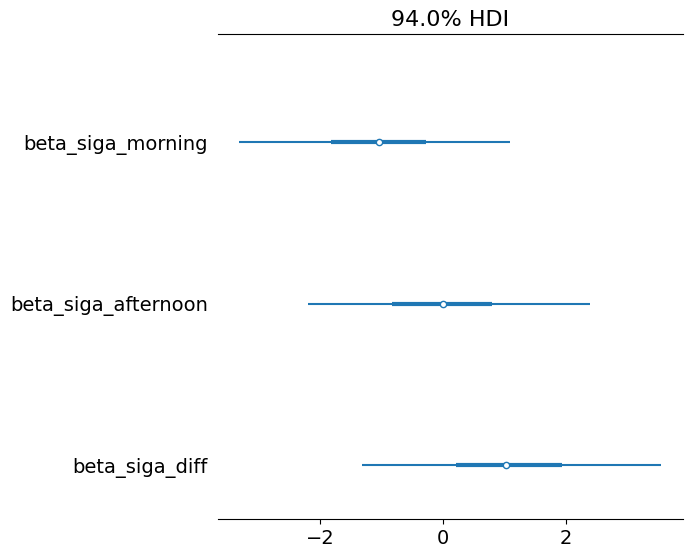

In [4]:
az.plot_forest(trace, var_names=["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"], combined=True)

In [9]:
summary = az.summary(
    trace,
    var_names=["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"],
    hdi_prob=0.95,
    stat_focus="mean",
    round_to=None
)
summary["var_names"] = summary.index
summary.to_csv("../data_for_figures/data_figure_E.csv", index=False)

In [6]:
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_siga_morning,-1.052,1.162,-3.450,1.175,0.049,0.030,562.0,766.0,1.01
beta_siga_afternoon,-0.009,1.206,-2.262,2.555,0.051,0.030,550.0,775.0,1.01
beta_siga_diff,1.063,1.275,-1.347,3.713,0.053,0.032,569.0,741.0,1.01


### **Bayesian Logistic Regression Model: IgA Predictors of Attachment Quality**

To examine whether immunological markers could predict attachment outcomes, we implemented a **Bayesian logistic regression model** using three secretory IgA (sIgA)-related variables—morning levels, afternoon levels, and intra-day change—as predictors of insecure attachment status. This framework allows us to estimate the probability of insecure attachment while avoiding potential confounds from endocrine measures such as cortisol.

#### **Model Estimates**

The model included an intercept ($\alpha$) and three regression coefficients ($\beta$):

| Parameter                  | Mean   | SD    | 94% HDI (lower) | 94% HDI (upper) |
| -------------------------- | ------ | ----- | --------------- | --------------- |
| $\alpha$                   | -0.693 | 0.445 | -1.518          | 0.141           |
| $\beta_{\text{morning}}$   | -1.071 | 1.128 | -3.143          | 1.024           |
| $\beta_{\text{afternoon}}$ | 0.044  | 1.161 | -2.127          | 2.140           |
| $\beta_{\text{diff}}$      | 0.999  | 1.225 | -1.280          | 3.268           |

As shown in the HDI plot, none of the coefficients' 94% credible intervals exclude zero, indicating considerable uncertainty around the direction and magnitude of the estimated effects.

#### **Interpretation of Coefficients**

* **Morning IgA**: The negative coefficient ($\beta = -1.071$) suggests that higher morning sIgA levels may be associated with a lower probability of insecure attachment. This aligns with the hypothesis that greater baseline mucosal immunity reflects improved psychobiological regulation.

* **Afternoon IgA**: The estimate near zero implies that afternoon IgA does not significantly distinguish between attachment groups. Afternoon levels may be more influenced by daily environmental variability and less stable as biomarkers of relational stress.

* **Intra-day difference**: The positive coefficient ($\beta = 0.999$) indicates that greater fluctuations in IgA across the day may be associated with higher risk of insecure attachment. This supports the view that immune stability may serve as a biological signature of regulatory competence linked to secure caregiving environments.

#### **Discussion**

Although the credible intervals for all coefficients include zero, the directionality of the effects is consistent with emerging psychoneuroimmunological theories. Specifically, securely attached infants may exhibit more stable immune functioning and reduced intra-day variability, which may act as a buffer against physiological stress.

These results also suggest that immune-based markers such as sIgA could contribute to models predicting attachment outcomes, especially when considered alongside traditional psychological or relational assessments. Notably, even in the absence of statistically strong effects, the trends observed are biologically plausible and consistent with previous research linking immune regulation with relational stability.

The observed inverse association between morning IgA and attachment insecurity supports the use of early-day immune markers as sensitive indicators of relationally modulated regulation. Meanwhile, the positive association between intra-day IgA variability and insecure attachment points to a potential dysregulation in immune rhythm, which may reflect higher chronic stress or lower regulatory efficiency.

#### **Limitations and Future Directions**

The lack of strong statistical evidence likely reflects limited sample size and high individual variability in IgA levels. Future studies should incorporate larger cohorts and consider modeling interactions with cortisol or other neuroendocrine variables. Additionally, including longitudinal assessments of both attachment and immune profiles could help capture developmental patterns and more robustly identify sensitive periods for psychobiological modulation.
